In [1]:
import pandas
import numpy as np

from skimage.io import imread
import matplotlib.pyplot as plt
import cv2
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from tqdm import tqdm

import torch
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD

# Potrebam pytgon interpreter sa PyTorch bibliotekom
# Uradjeno na NVIDIA grafickom karticom sa CUDA-om

In [2]:
print(torch.cuda.is_available())
csv_fajl = pandas.read_csv(r"C:\Users\User\Desktop\AI\chest_xray_metadata.csv")  # promeniti na svoju lokaciju

csv_fajl = csv_fajl[csv_fajl.Label_1_Virus_category != 'Stress-Smoking']
# uklanjamo pusace zbog manjka slika (takodje je tako navedeno u zadatku)

train_y = np.ndarray(0)

for index, row in csv_fajl.iterrows():
    if row['Label'] != 'Normal':
        if str(row['Label_2_Virus_category']) != 'nan':
            if row['Label_2_Virus_category'] == 'Streptococcus':
                #csv_fajl.at[str(index), 'Label'] = 3
                train_y = np.append(train_y, 3)
                #row['Label'] = 3
            elif row['Label_2_Virus_category'] == 'COVID-19':
                #csv_fajl.at[str(index), 'Label'] = 4
                train_y = np.append(train_y, 4)
                #row['Label'] = 4
            elif row['Label_2_Virus_category'] == 'ARDS':
                #csv_fajl.at[str(index), 'Label'] = 5
                train_y = np.append(train_y, 5)
                #row['Label'] = 5
            elif row['Label_2_Virus_category'] == 'SARS':
                #csv_fajl.at[str(index), 'Label'] = 6
                train_y = np.append(train_y, 6)
                #row['Label'] = 6
            else:
                print('promaseno ' + row['Label_2_Virus_category'])
            # print(row['Label'], " => " , row['Label_1_Virus_category'], "|", row['Label_2_Virus_category'])#, row['X_ray_image_name'])
        else:
            if row['Label_1_Virus_category'] == 'Virus':
                #csv_fajl.at[str(index), 'Label'] = 1
                train_y = np.append(train_y, 1)
                #row['Label'] = 1
            elif row['Label_1_Virus_category'] == 'bacteria':
                #csv_fajl.at[str(index), 'Label'] = 2
                train_y = np.append(train_y, 2)
                #row['Label'] = 2
            else:
                print('promaseno ' + row['Label_1_Virus_category'])
            # print(row['Label'], " => " , row['Label_1_Virus_category'], "|", row['Label_2_Virus_category'])#, row['X_ray_image_name'])
    else:
        #csv_fajl.at[str(index), 'Label'] = 0
        train_y = np.append(train_y, 0)
        #row['Label'] = 0

True


# /\ kod za ucitavanje i obradu informacija iz fajla
# |                                                                             
# V kod za kupljenje slika u niz

In [3]:
csv_fajl.head()
img_niz = []
for index, row in csv_fajl.iterrows():
    img_name = row['X_ray_image_name']
    lokacija = 'C:/Users/User/Desktop/AI/snimci/' + str(img_name)
    slika = imread(lokacija, as_gray=True)/255.0
    slika = cv2.resize(slika, dsize=(50, 50), interpolation=cv2.INTER_CUBIC)
    slika = slika.astype('float32')
    img_niz.append(slika)


train_x = np.array(img_niz)
#train_y = csv_fajl['Label'].values
train_x.shape

(5284, 50, 50)

In [4]:
#img_niz = []#brisanje slika (za oslobadjanje memorije)

# /\ Kod za oslobadjanje memorije 
# V Prikaz prve 4 slike

(<matplotlib.axes._subplots.AxesSubplot at 0x1fbc3dbf4c8>,
 <matplotlib.image.AxesImage at 0x1fbc3e2af48>)

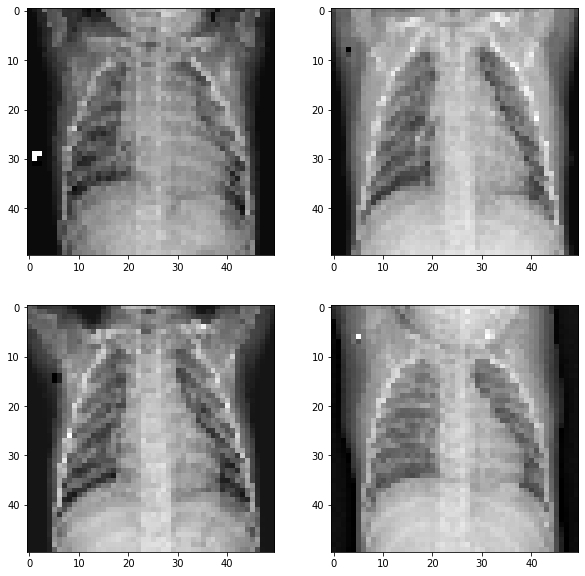

In [5]:
plt.figure(figsize=(10,10))
plt.subplot(221), plt.imshow(train_x[0], cmap='gray')
plt.subplot(222), plt.imshow(train_x[1], cmap='gray')
plt.subplot(223), plt.imshow(train_x[2], cmap='gray')
plt.subplot(224), plt.imshow(train_x[3], cmap='gray')

In [6]:
train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, test_size = 0.1)
(train_x.shape, train_y.shape), (val_x.shape, val_y.shape)

(((4755, 50, 50), (4755,)), ((529, 50, 50), (529,)))

In [7]:
train_x = train_x.reshape(4755, 1, 50, 50)
train_x  = torch.from_numpy(train_x)

train_y = train_y.astype(int);
train_y = torch.from_numpy(train_y)


val_x = val_x.reshape(529, 1, 50, 50)
val_x  = torch.from_numpy(val_x)

val_y = val_y.astype(int);
val_y = torch.from_numpy(val_y)


# val_x = val_x.reshape(529, 1, 50, 50)
# val_x  = torch.from_numpy(val_x)

In [8]:
train_x.shape, train_y.shape
val_x.shape, val_y.shape

(torch.Size([529, 1, 50, 50]), torch.Size([529]))

# Kreiranje CNN-a

In [9]:
class Net(Module):   
    def __init__(self):
        super(Net, self).__init__()

        self.cnn_layers = Sequential(
            # Defining a 2D convolution layer
            Conv2d(1, 4, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(4),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=2, stride=2),
            # Defining another 2D convolution layer
            Conv2d(4, 4, kernel_size=3),
            BatchNorm2d(4),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=2, stride=2),
        )

        self.linear_layers = Sequential(
            Linear(484, 7)#, Linear(484, 7) #[4755 x 484], m2: [4755 x 7]
            #[4755 x 484], m2: [4755 x 7]
            #m1: [4755 x 484], m2: [4755 x 484] 
        )
    
    def forward(self, x):
        x = x.float()
        x = self.cnn_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x

Pravljenje modela

In [10]:
model = Net()
# defining the optimizer
optimizer = Adam(model.parameters(), lr=0.07)
# defining the loss function
criterion = CrossEntropyLoss()
# checking if GPU is available
if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()
    
print(model)

Net(
  (cnn_layers): Sequential(
    (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1))
    (5): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear_layers): Sequential(
    (0): Linear(in_features=484, out_features=7, bias=True)
  )
)


In [11]:
def train(epoch):
    model.train()
    tr_loss = 0
    # getting the training set
    ###### x_train, y_train = Variable(train_x), Variable(train_y)
    x_train = torch.from_numpy(np.array(train_x))
    y_train = torch.from_numpy(np.array(train_y))
    # getting the validation set
    ###### x_val, y_val = Variable(val_x), Variable(val_y)
    x_val = torch.from_numpy(np.array(val_x))
    y_val = torch.from_numpy(np.array(val_y))
    # converting the data into GPU format
    if torch.cuda.is_available():
        x_train = x_train.cuda()
        y_train = y_train.cuda()
        x_val = x_val.cuda()
        y_val = y_val.cuda()

    # clearing the Gradients of the model parameters
    optimizer.zero_grad()
    
    # prediction for training and validation set
    output_train = model(x_train)
    output_val = model(x_val)

    # computing the training and validation loss
    loss_train = criterion(output_train, y_train)
    loss_val = criterion(output_val, y_val)
    train_losses.append(loss_train)
    val_losses.append(loss_val)

    # computing the updated weights of all the model parameters
    loss_train.backward()
    optimizer.step()
    tr_loss = loss_train.item()
    if epoch%2 == 0:
        # printing the validation loss
        print('Epoch : ',epoch+1, '\t', 'loss :', loss_val)

#  Treniranje modela

In [12]:
n_epochs = 4

train_losses = []
val_losses = []

for epoch in range(n_epochs):
    train(epoch)

RuntimeError: Expected object of scalar type Long but got scalar type Int for argument #2 'target' in call to _thnn_nll_loss_forward

# Crtanje grafika

In [ ]:
# plotting the training and validation loss
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend()
plt.show()
